# Explore how Secondary Candidates affect $P(O|x)$

In [10]:
# imports
from importlib import reload
import os
from pkg_resources import resource_filename

import numpy as np
import pandas
from matplotlib import pyplot as plt

from astropy.coordinates import SkyCoord
from astropy import units

from astropath import path
from astropath import localization

## Dummy FRB 

## Instantiate PATH

In [2]:
Path = path.PATH()

## Localization

In [3]:
## FRB Coord
frb_coord = SkyCoord('21h44m25.255s -40d54m00.10s', frame='icrs')
frb_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (326.10522917, -40.90002778)>

## Error ellipse

In [4]:
eellipse = dict(a=0.2, b=0.2, theta=0.)

### Set it

In [5]:
Path.init_localization('eellipse', center_coord=frb_coord, eellipse=eellipse)

# Priors

## Offset

In [8]:
Path.init_theta_prior('exp', 6., 0.5)

# Create faux Candidates

## Primary 

In [47]:
pri_angsize = 1. # arcsec
pri_coord1 = frb_coord.directional_offset_by(0.*units.deg, 1*pri_angsize*units.arcsec)
pri_coord2 = frb_coord.directional_offset_by(0.*units.deg, 2*pri_angsize*units.arcsec)
pri_mags = [19., 20., 21., 22., 23.]
pri_clrs = ['k','b','r','g', 'gray']

## Secondary

In [53]:
sec_angsize = 1. # arcsec
sec_mags = np.linspace(21., 25., 40)
sec_offsets = [2, 3, 4] # in units of angsize
sec_ls = ['-', ':', '--']

# Loop and run PATH with PS1 in mind

In [54]:
def run_path(survey:str, pri_coord):
    out_dict = {}
    for pri_mag in pri_mags:
        out_dict[pri_mag] = {}
        for sec_off in sec_offsets:
            out_dict[pri_mag][sec_off] = {}
            out_dict[pri_mag][sec_off]['POx'] = []
            out_dict[pri_mag][sec_off]['PUx'] = []
            # Let's go
            for sec_mag in sec_mags:
                sec_coord = frb_coord.directional_offset_by(0*units.deg, sec_off*sec_angsize*units.arcsec)
                candidates = pandas.DataFrame(dict(ra=[pri_coord.ra.deg, sec_coord.ra.deg], 
                                                   dec=[pri_coord.dec.deg, sec_coord.dec.deg],
                                                   half_light=[pri_angsize, sec_angsize],
                                                   mag=[pri_mag, sec_mag]))
                # Candidates
                Path.init_candidates(candidates.ra.values,
                         candidates.dec.values,
                         candidates.half_light.values,
                         mag=candidates.mag.values)
                # Priors
                if survey == 'PS1':
                    Path.init_cand_prior('inverse', P_U=0.32)  # PS1
                elif survey == 'DEC':
                    Path.init_cand_prior('inverse', P_U=0.15)  # PS1
                else:
                    raise IOError("Bad survey")
                Path.calc_priors()
                # Posteriors
                P_Ox, P_Ux = Path.calc_posteriors('fixed', box_hwidth=10., max_radius=10.)
                # Save
                out_dict[pri_mag][sec_off]['POx'].append(P_Ox[0])
                out_dict[pri_mag][sec_off]['PUx'].append(P_Ux)
    return out_dict                

In [55]:
ps_out1 = run_path('PS1', pri_coord1)

# Time to Plot

In [73]:
def make_plot(out_dict, survey:str, offset):
    fig = plt.figure(figsize=(7,7))
    ax = plt.gca()
    
    for clr, pri_mag in zip(pri_clrs, pri_mags):
        if survey == 'PS1' and pri_mag > 22:
            continue
        for ls, sec_off in zip(sec_ls, sec_offsets):
            ax.plot(sec_mags,  out_dict[pri_mag][sec_off]['POx'], label=f'mp={pri_mag}, soff={sec_off}',
                   color=clr, ls=ls)
    #
    if survey == 'PS1':
        ax.set_xlim(23., np.min(sec_mags))
    else:
        ax.set_xlim(np.max(sec_mags), 22.)
    ax.set_ylim(0, 1.)
    ax.legend()
    #
    ax.set_xlabel('Secondary mag')
    ax.set_ylabel('Primary P(O|x)')
    # Title
    ax.set_title(f'{survey} with Primary offset by {offset}')
    plt.show()

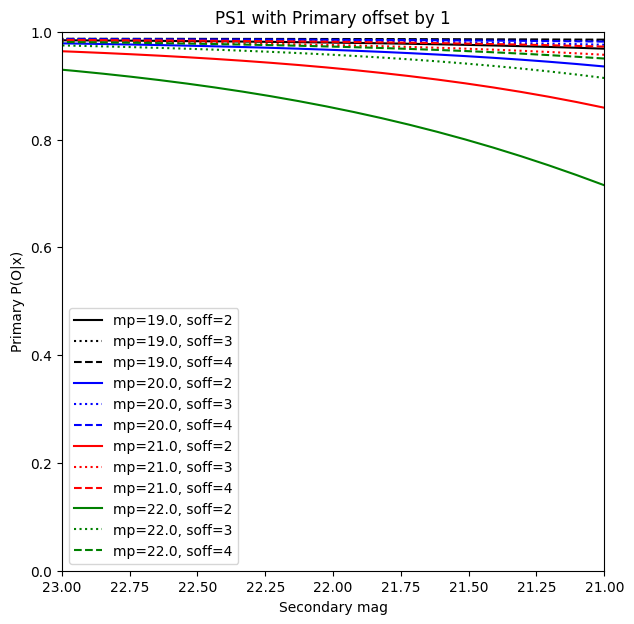

In [69]:
make_plot(ps_out1, "PS1", 1)

# Now DECaLS

In [71]:
dec_out1 = run_path('DEC', pri_coord)

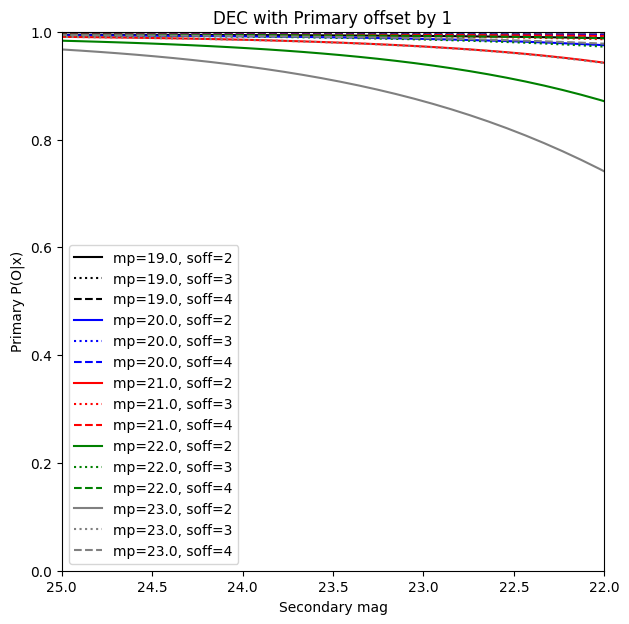

In [74]:
make_plot(dec_out1, "DEC", 1)

# Now Primary offset by 2

In [75]:
ps_out2 = run_path('PS1', pri_coord2)

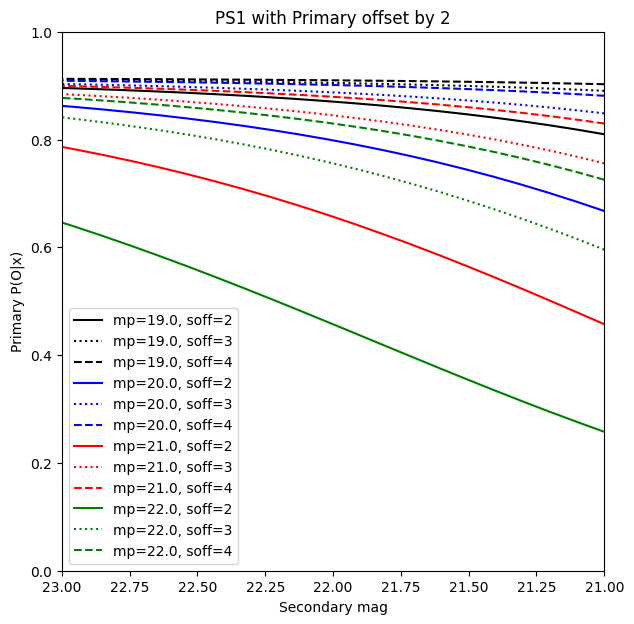

In [76]:
make_plot(ps_out2, "PS1", 2)

In [77]:
dec_out2 = run_path('DEC', pri_coord2)

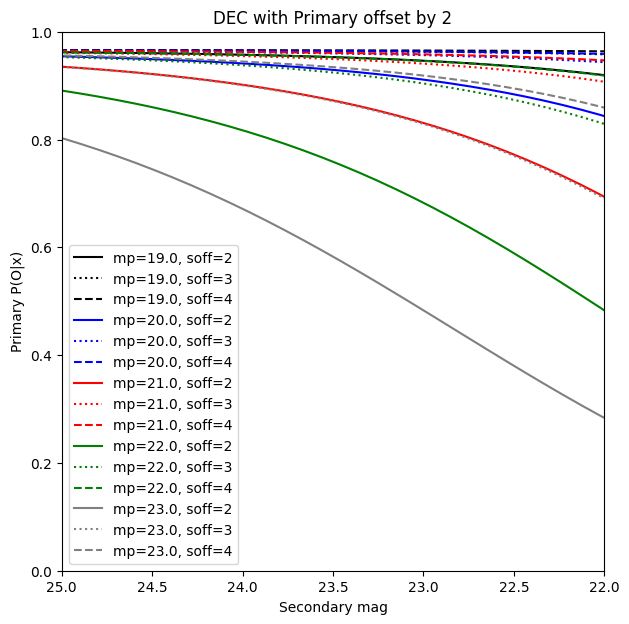

In [79]:
make_plot(dec_out2, "DEC",2)